In [1]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from hdbscan import HDBSCAN, approximate_predict
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics.pairwise import euclidean_distances
import numpy as np
from matplotlib import pyplot as plt
import joblib
import json
import os
import cv2


In [22]:
def train_model(data, method_reduction='pca', n_components=2, method_cluster = 'kmeans', n_clusters=4):
    # Apply dimensionality reduction
    if method_reduction == 'pca':
        drmethod = PCA(n_components=n_components, random_state=0)
    else:
        raise ValueError("Invalid method. Choose 'pca'.")
    
    reduced_data = drmethod.fit_transform(data)
    
    # Clusterize the reduced data
    if 'kmeans' in method_cluster:
        clmethod = KMeans(n_clusters=n_clusters)
    elif 'dbscan' in method_cluster:
        clmethod = DBSCAN(eps=0.3, min_samples=10)
    elif 'hdbscan' in method_cluster:
        clmethod = HDBSCAN(min_cluster_size=15, prediction_data = True)
    else:
        raise ValueError("Invalid method. Choose 'kmeans', 'dbscan' or 'hdbscan'.")
    
    print('Cluster method applied to reduced data')
    clmethod.fit(reduced_data)
    
    # print(f'TRAIN CLUSTERS CENTER: {clmethod.cluster_centers_}')
    print(f'TRAIN CLUSTER LABELS: {clmethod.labels_}')
    print(clmethod)
    
    # # Save the model
    # joblib.dump(kmeans, 'model.pkl')
    # #save the dimensionality reduction model
    # joblib.dump(drmethod, 'drmodel.pkl')
    
    return reduced_data, drmethod, clmethod


In [54]:
#image data path 
datapath = '/mnt/atlas/data_KPIs/data/KPIs24_Training_Data/Task1_patch_level/train/'

#validation fold 
val_fold = 0

#define parameters
cluster_method = 'kmeans'
n_clusters = 4
reduction_method = 'pca'

### read csv file
df = pd.read_csv('/home/benito/script/KPIs24/results/glomeroulous_features/radiomics_features_entire_train_patches_by_glomeruli.csv')
# #remove wavelet features
df = df[df.columns.drop(list(df.filter(regex='wavelet')))]
# #remove shape features
# df = df[df.columns.drop(list(df.filter(regex='shape')))]

#get train and test data from json file
# Specify the file path
split = {}
nfolds = 3
for i in range(nfolds):
    file_path = f'/home/benito/script/NephroBIT/split_json/fold_{i}.json'
    with open(file_path, 'r') as file:
        split_fold = json.load(file)
    split.update(split_fold)
    if val_fold == i:
        patients_val = np.unique([case['case_id'] for case in split_fold['cases']])

patients_train = np.unique([case['case_id'] for case in split['cases'] if case not in patients_val])

df_test = df[df['id'].isin(patients_val)]
df_test.reset_index(drop=True, inplace=True)
df_train = df[~df['id'].isin(patients_val)]
df_train.reset_index(drop=True, inplace=True)

#remove nan values
df_train = df_train.dropna()
df_test = df_test.dropna()

#normalize data (z-score) in the train and apply to the test
df_train_norm = df_train.copy()
df_test_norm = df_test.copy()
for column in df_train.columns[3:]:
    mean = df_train[column].mean()
    std = df_train[column].std()
    df_train_norm[column] = (df_train[column] - mean) / std
    df_test_norm[column] = (df_test[column] - mean) / std


In [55]:
# Train the model
train_data, dimensionality_reduction_model, cluster_model = train_model(df_train_norm.iloc[:,3:], method_reduction=reduction_method, n_components=2, method_cluster = cluster_method, n_clusters=n_clusters)
# test_data(df_test, dimensionality_reduction_model, cluster_model)

Cluster method applied to reduced data
TRAIN CLUSTER LABELS: [0 0 3 ... 0 0 0]
KMeans(n_clusters=4)


In [56]:
df_train_data = df_train.iloc[:,:3]
df_train_data.reset_index(drop=True, inplace=True)
df_train_data = pd.concat([df_train_data, pd.DataFrame(train_data, columns=['pca1', 'pca2'])], axis=1)
#associate to each point its cluster calculated with the cluster model
df_train_data['cluster'] = cluster_model.labels_

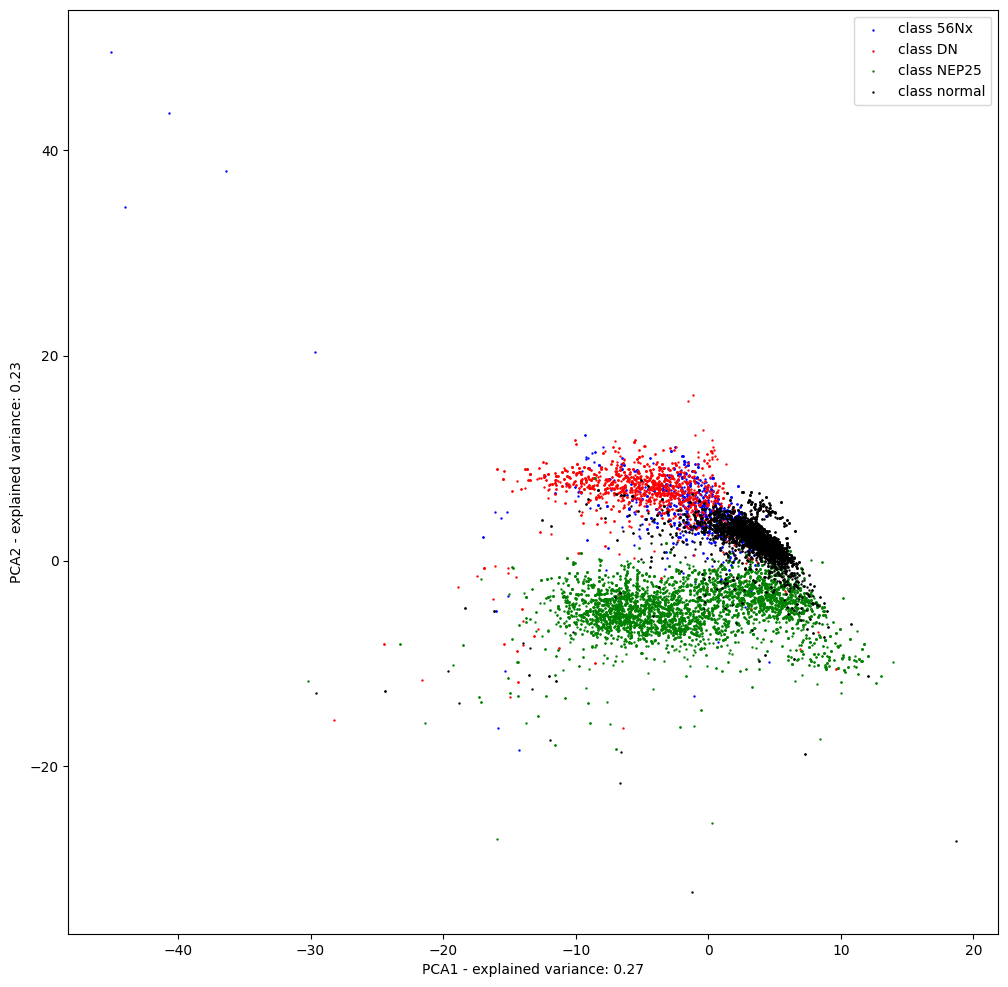

In [57]:
### scatter plot stratiying by class
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot()

colors = ['blue', 'red', 'green', 'black']
for i, class_glom in enumerate(df_train_data['class'].unique()):
    ax.scatter(df_train_data[df_train_data['class'] == class_glom]['pca1'], df_train_data[df_train_data['class'] == class_glom]['pca2'], c=colors[i], label=f'class {class_glom}', s=0.5)
    #add axis labels to the plot
ax.set_xlabel(f'PCA1 - explained variance: {dimensionality_reduction_model.explained_variance_ratio_[0]:.2f}')
ax.set_ylabel(f'PCA2 - explained variance: {dimensionality_reduction_model.explained_variance_ratio_[1]:.2f}')
# ax.set_zlabel(f'PCA3 - explained variance: {dimensionality_reduction_model.explained_variance_ratio_[2]:.2f}')
ax.legend()
plt.show()


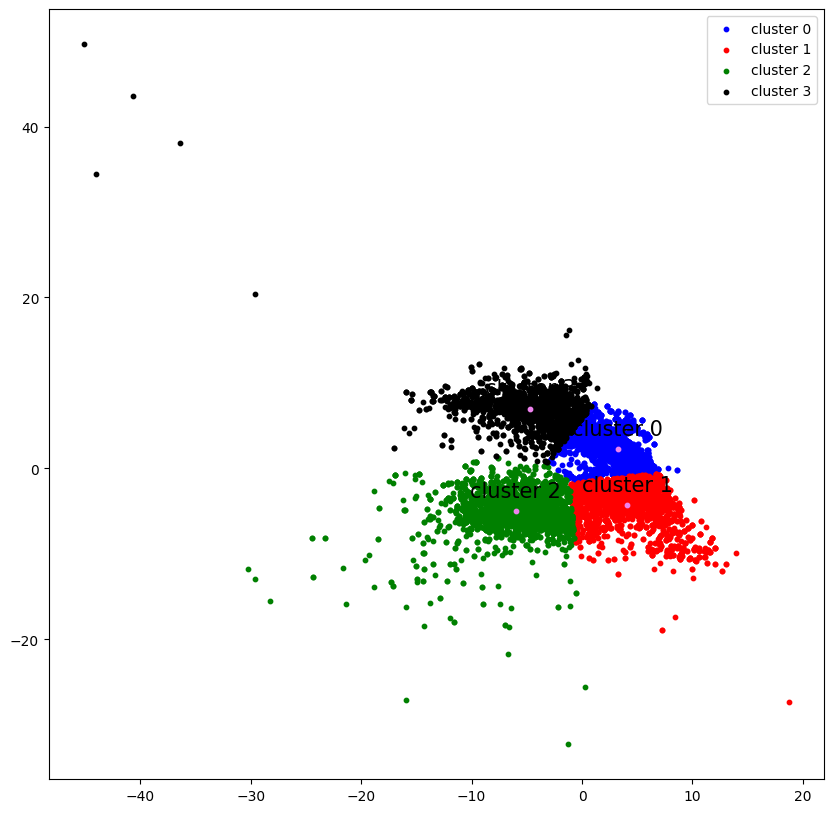

In [58]:
from matplotlib import cm
### scatter plot stratiying by cluster
fig, ax = plt.subplots(figsize=(10, 10))
# colors = ['blue', 'red', 'green', 'black']

colors = (['black'] + list(cm.tab10(np.linspace(0, 1, df_train_data['cluster'].unique().shape[0] -1)))  if 'dbscan' in cluster_method  else  ['blue', 'red', 'green', 'black', 'gray', 'purple'])

for i, cluster in enumerate(sorted(df_train_data['cluster'].unique())):
    ax.scatter(df_train_data[df_train_data['cluster'] == cluster]['pca1'], df_train_data[df_train_data['cluster'] == cluster]['pca2'], c=colors[i], label=f'cluster {cluster}', s=(1 if cluster == -1 else 10))
ax.legend()

if cluster_method == 'kmeans':
    for i, cluster in enumerate(cluster_model.cluster_centers_):
        ax.scatter(cluster[0], cluster[1], c='violet', s=10)
        plt.annotate(f'cluster {i}', (cluster[0], cluster[1]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=15)
plt.show()


In [59]:
#calculate the distance of the test data to the cluster centers
closest_cluster, distances_values = pairwise_distances_argmin_min(train_data, cluster_model.cluster_centers_)
print(f'CLOSEST CLUSTER: {closest_cluster}' )
print(f'DISTANCES BETWEEN CLUSTERS CENTERS: {distances_values}')
distances_train_df = pd.DataFrame()
distances_train_df['id'] = df_train_data['id']
distances_train_df['class'] = df_train_data['class']
distances_train_df['id_patch'] = df_train_data['id_patch']
distances_train_df['distance'] = distances_values
distances_train_df['cluster'] = df_train_data['cluster']
distances_train_df['pca1'] = df_train_data['pca1']
distances_train_df['pca2'] = df_train_data['pca2']
distances_train_df.describe()


CLOSEST CLUSTER: [0 0 3 ... 0 0 0]
DISTANCES BETWEEN CLUSTERS CENTERS: [2.35380518 2.35380518 1.58000697 ... 0.50275066 0.89628426 1.13884751]


,distance,cluster,pca1,pca2
count,14650.000000,14650.000000,14650.000000,1.465000e+04
mean,2.727370,1.144505,0.000000,-1.241631e-16
std,2.050516,1.119859,5.199239,4.860277e+00
min,0.010095,0.000000,-45.083357,-3.226985e+01
25%,1.388301,0.000000,-3.784762,-4.090776e+00
50%,2.431414,1.000000,1.312737,8.027076e-01
75%,3.652753,2.000000,4.090107,3.255706e+00
max,58.706556,3.000000,18.704455,4.961877e+01


In [60]:
#clusters identified by kmeans
if cluster_method == 'kmeans':
    dists_clusters = euclidean_distances(cluster_model.cluster_centers_)
    print(f'DISTANCE BETWEEN CLUSTERS: {dists_clusters}')

DISTANCE BETWEEN CLUSTERS: [[ 0.          6.65499726 11.77417442  9.22861145]
 [ 6.65499726  0.         10.10122495 14.32463812]
 [11.77417442 10.10122495  0.         12.10043133]
 [ 9.22861145 14.32463812 12.10043133  0.        ]]


In [61]:
# Apply dimensionality reduction to test data
test_pca = dimensionality_reduction_model.transform(df_test_norm.iloc[:,3:])
df_test_pca = df_test.iloc[:,:3]
df_test_pca.reset_index(drop=True, inplace=True)
df_test_pca = pd.concat([df_test_pca, pd.DataFrame(test_pca, columns=['pca1', 'pca2'])], axis=1)
if cluster_method == 'hdbscan':
    predictions = approximate_predict(cluster_model, test_pca)
    df_test_pca['cluster'] = predictions[0]
    df_test_pca['probabilty_cluster'] = predictions[1]
elif cluster_method == 'kmeans':
    df_test_pca['cluster'] = cluster_model.predict(test_pca)
else:
    raise Exception('Invalid cluster method or predict not implemented!')

# Check if the data belong to one of the clusters defined by the model
# cluster_centers = cluster_model.cluster_centers_
# print(f'TRAIN CLUSTERS CENTER: {cluster_centers}')
# print(f'TRAIN CLUSTER LABELS: {np.unique(cluster_model.labels_)}')

# distances = euclidean_distances(df_test_pca[['pca1', 'pca2']], cluster_model.cluster_centers_)

# #calculate the distance of the test data to the cluster centers
# # closest_cluster, distances = pairwise_distances_argmin_min(reduced_test_data, cluster_centers)
# # print(f'CLOSEST CLUSTER: {closest_cluster}' )
# print(f'DISTANCES BETWEEN CLUSTERS CENTERS: {distances}')
# distances = pd.DataFrame(distances)
# distances.describe()

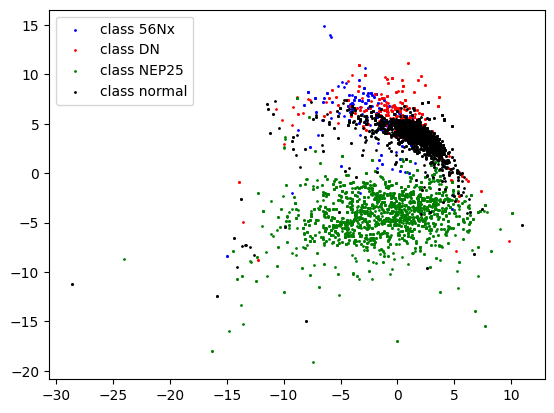

In [62]:
### scatter plot stratiying by class
fig, ax = plt.subplots()
colors = ['blue', 'red', 'green', 'black']
for i, class_glom in enumerate(sorted(df_test_pca['class'].unique())):
    ax.scatter(df_test_pca[df_test_pca['class'] == class_glom]['pca1'], df_test_pca[df_test_pca['class'] == class_glom]['pca2'], c=colors[i], label=f'class {class_glom}', s=1)
    # ax.set_xlim(-2, 2)  # Set x-axis limits
ax.legend()

plt.show()


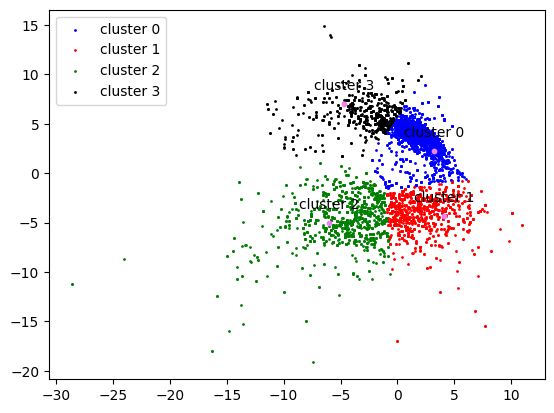

In [63]:
### scatter plot stratiying by cluster
fig, ax = plt.subplots()
colors = (['black'] + list(cm.tab10(np.linspace(0, 1, df_train_data['cluster'].unique().shape[0] -1)))  if 'dbscan' in cluster_method else  ['blue', 'red', 'green', 'black'])

for i, cluster in enumerate(sorted(df_test_pca['cluster'].unique())):
    ax.scatter(df_test_pca[df_test_pca['cluster'] == cluster]['pca1'], df_test_pca[df_test_pca['cluster'] == cluster]['pca2'], c=colors[i], label=f'cluster {cluster}', s=1)
ax.legend()
if cluster_method == 'kmeans':
    cluster_centers = cluster_model.cluster_centers_
    #add a point for each cluster
    for i, cluster in enumerate(cluster_centers):
        ax.scatter(cluster[0], cluster[1], c='violet', s=10)
        plt.annotate(f'cluster {i}', (cluster[0], cluster[1]), textcoords="offset points", xytext=(0,10), ha='center')
plt.show()


In [64]:
### find point that are far from the cluster centers
distances = euclidean_distances(df_test_pca[['pca1', 'pca2']], cluster_model.cluster_centers_)


In [65]:
#calculate the distance of the test data to the cluster centers
closest_cluster, distances_values = pairwise_distances_argmin_min(test_pca, cluster_model.cluster_centers_)
print(f'CLOSEST CLUSTER: {closest_cluster}' )
print(f'DISTANCES BETWEEN CLUSTERS CENTERS: {distances}')
distances_test_df = pd.DataFrame()
distances_test_df['id'] = df_test['id']
distances_test_df['class'] = df_test['class']
distances_test_df['id_patch'] = df_test['id_patch']
distances_test_df['distance'] = distances_values
distances_test_df['cluster'] = df_test_pca['cluster']
distances_test_df['pca1'] = df_test_pca['pca1']
distances_test_df['pca2'] = df_test_pca['pca2']
distances_test_df.describe()


CLOSEST CLUSTER: [3 3 3 ... 0 0 3]
DISTANCES BETWEEN CLUSTERS CENTERS: [[11.72878614 16.43328121 12.71011733  2.58731513]
 [ 6.3728707  11.98979441 11.84998359  2.9616059 ]
 [11.72878614 16.43328121 12.71011733  2.58731513]
 ...
 [ 4.04912918 10.09796185 11.84183306  5.33304401]
 [ 4.06854099 10.2666899  12.21695559  5.47971315]
 [ 4.70304592 10.53754896 11.61877258  4.6049933 ]]


,distance,cluster,pca1,pca2
count,6176.000000,6176.000000,6176.000000,6176.000000
mean,2.848690,0.955959,0.095609,0.725762
std,1.589516,1.081611,3.499601,4.544141
min,0.066039,0.000000,-28.635375,-19.150925
25%,1.682449,0.000000,-1.631124,-3.480065
50%,2.741815,1.000000,0.941360,2.785970
75%,3.858416,2.000000,2.484973,4.310974
max,23.475178,3.000000,10.983749,14.849031


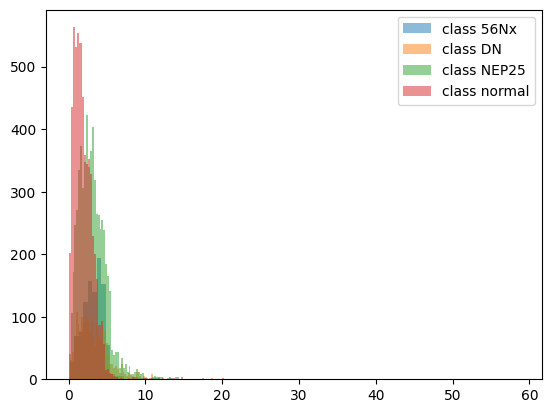

In [66]:
#histogram of distances to the cluster centers by class
fig, ax = plt.subplots()
for i, class_glom in enumerate(sorted(df_train_data['class'].unique())):
    ax.hist(distances_train_df[distances_train_df['class'] == class_glom]['distance'], bins=100, alpha=0.5, label=f'class {class_glom}')
ax.legend() 
plt.show()


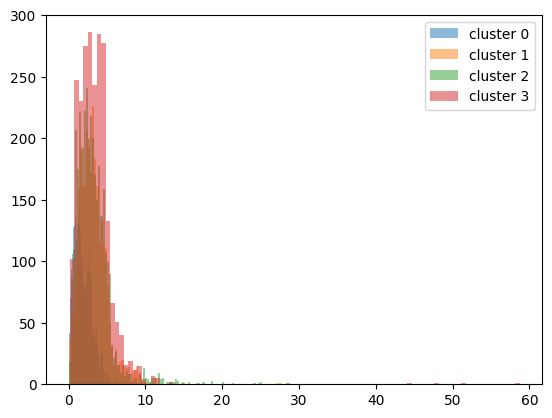

In [67]:
#histogram of distances to the cluster centers by class
fig, ax = plt.subplots()
for i, class_glom in enumerate(sorted(df_train_data['cluster'].unique())):
    ax.hist(distances_train_df[distances_train_df['cluster'] == class_glom]['distance'], bins=100, alpha=0.5, label=f'cluster {class_glom}')
ax.legend() 
plt.show()


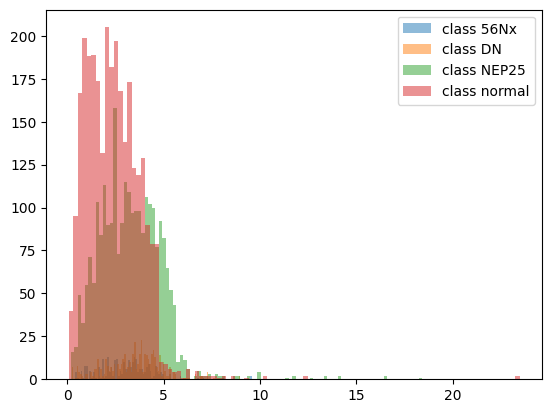

In [68]:
#histogram of distances to the cluster centers by class
fig, ax = plt.subplots()
for i, class_glom in enumerate(sorted(df_test_pca['class'].unique())):
    ax.hist(distances_test_df[distances_test_df['class'] == class_glom]['distance'], bins=100, alpha=0.5, label=f'class {class_glom}')
ax.legend() 
plt.show()


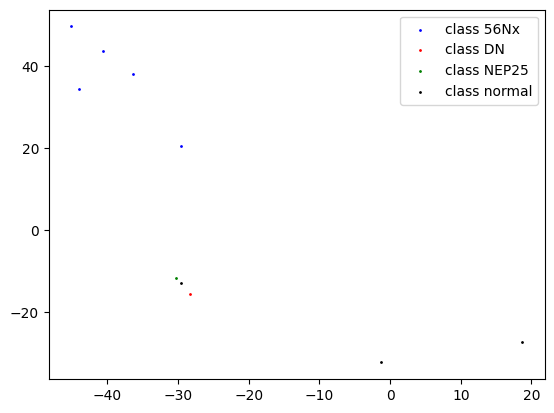

In [69]:
#image to check: get the images with the highest distance to the cluster centers and check if they are outliers
distances_train_df.sort_values(by='distance', ascending=False, inplace=True)
distances_train_df.reset_index(drop=True, inplace=True)

#check the images with the highest distance to the cluster centers
df_train_outliers = distances_train_df.head(10)

#scatter plot of the outliers
fig, ax = plt.subplots()
colors = ['blue', 'red', 'green', 'black']
for i, class_glom in enumerate(sorted(df_train_outliers['class'].unique())):
    ax.scatter(df_train_outliers[df_train_outliers['class'] == class_glom]['pca1'], df_train_outliers[df_train_outliers['class'] == class_glom]['pca2'], c=colors[i], label=f'class {class_glom}', s=1)
    # ax.set_xlim(-2, 2)  # Set x-axis limits
ax.legend()
plt.show()



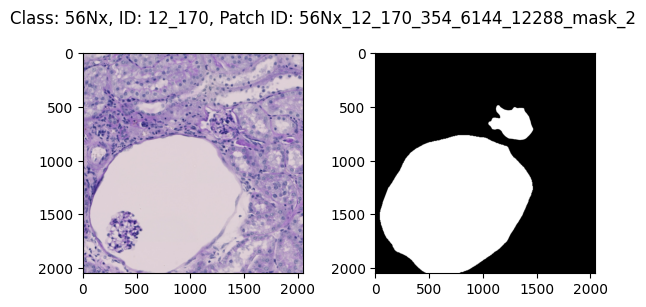

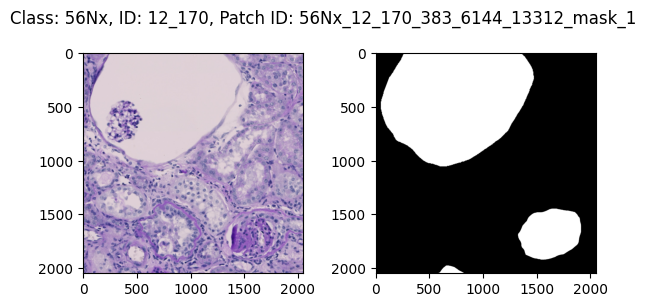

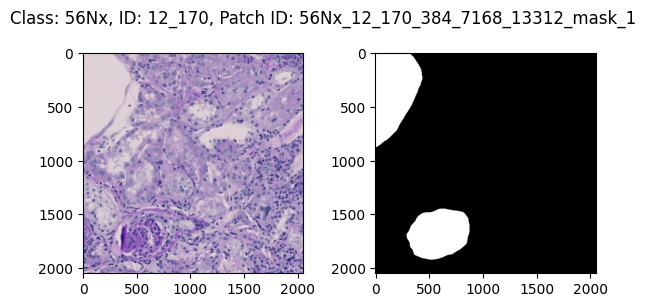

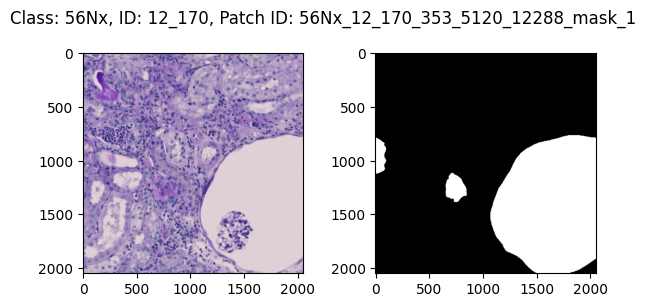

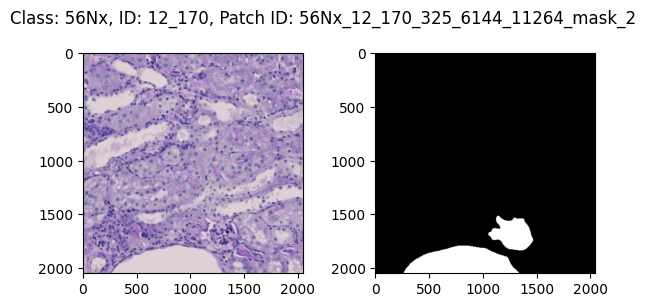

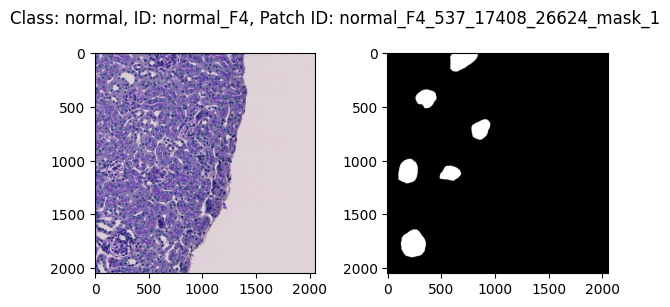

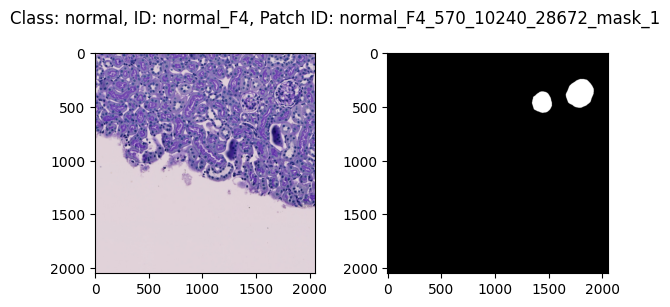

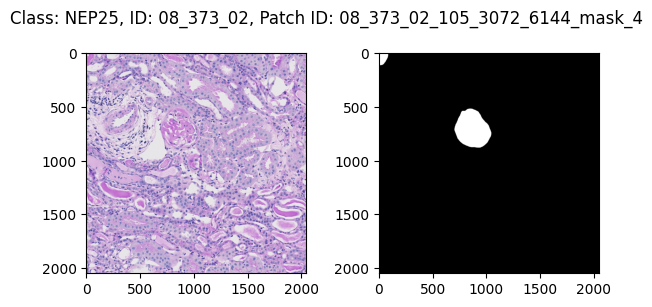

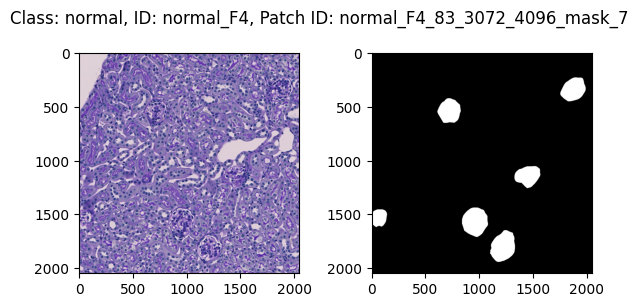

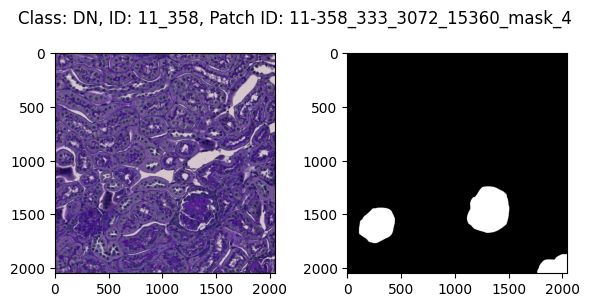

In [70]:
#load and plot image and mask in the same subplot for all the outliers in the test set
for i, row in df_train_outliers.iterrows():
    image_path = os.path.join(datapath, row['class'], row['id'], 'img', row['id_patch'].split('_mask')[0] + '_img.jpg')
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask_path = os.path.join(datapath, row['class'], row['id'], 'mask', row['id_patch'].split('_mask')[0] + '_mask.jpg')
    mask = cv2.imread(mask_path)
    fig, ax = plt.subplots(1, 2, figsize=(6, 3))
    fig.suptitle(f'Class: {row["class"]}, ID: {row["id"]}, Patch ID: {row["id_patch"]}')
    ax[0].imshow(image)
    ax[1].imshow(mask)
    #tight layout
    plt.tight_layout()
    plt.show()
    
#mask data path


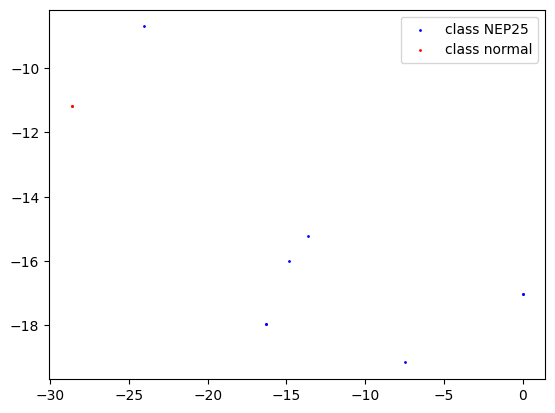

In [71]:
#image to check: get the images with the highest distance to the cluster centers and check if they are outliers
distances_test_df.sort_values(by='distance', ascending=False, inplace=True)
distances_test_df.reset_index(drop=True, inplace=True)

#check the images with the highest distance to the cluster centers
df_test_outliers = distances_test_df.head(10)

#scatter plot of the outliers
fig, ax = plt.subplots()
colors = ['blue', 'red', 'green', 'black']
for i, class_glom in enumerate(sorted(df_test_outliers['class'].unique())):
    ax.scatter(df_test_outliers[df_test_outliers['class'] == class_glom]['pca1'], df_test_outliers[df_test_outliers['class'] == class_glom]['pca2'], c=colors[i], label=f'class {class_glom}', s=1)
    # ax.set_xlim(-2, 2)  # Set x-axis limits
ax.legend()
plt.show()



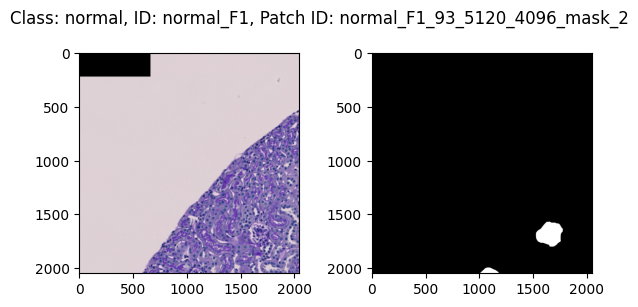

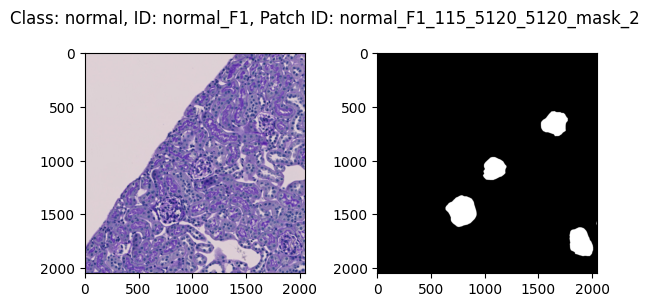

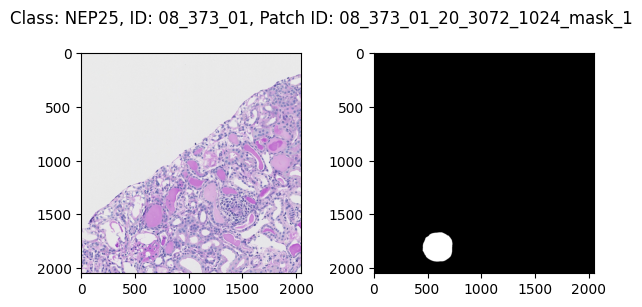

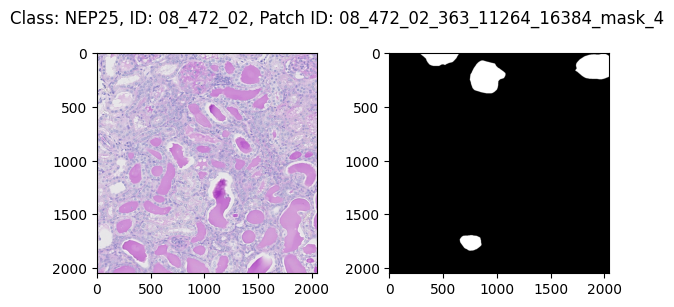

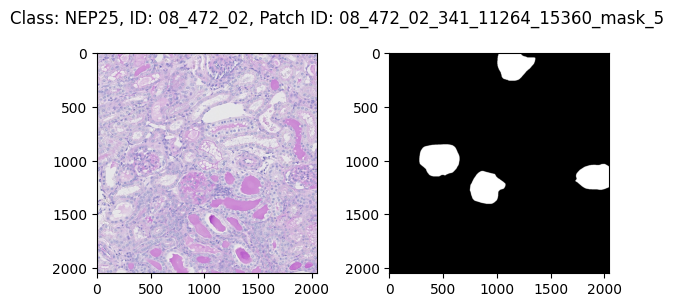

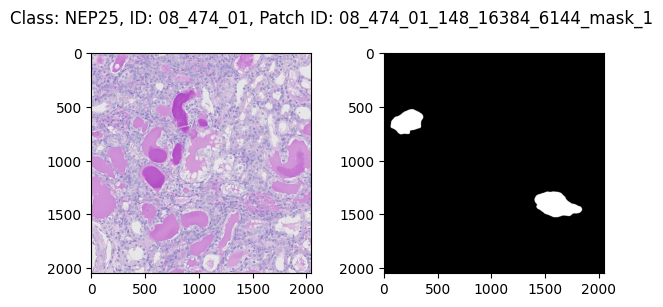

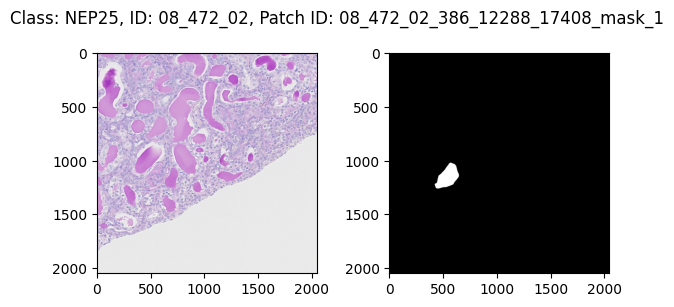

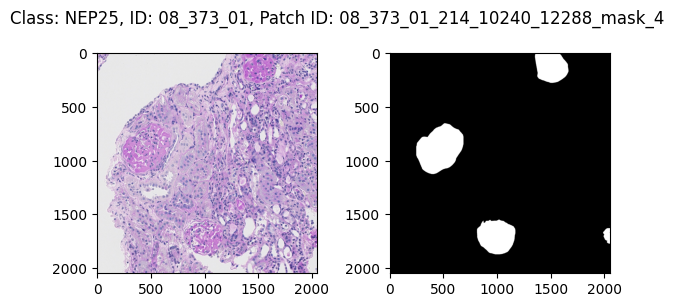

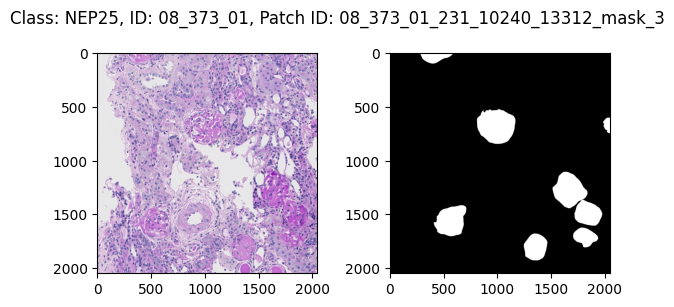

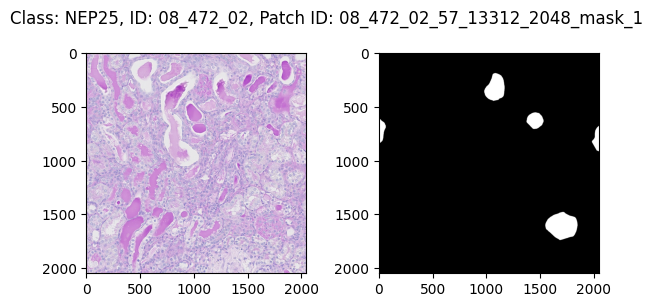

In [72]:
#load and plot image and mask in the same subplot for all the outliers in the test set
for i, row in df_test_outliers.iterrows():
    image_path = os.path.join(datapath, row['class'], row['id'], 'img', row['id_patch'].split('_mask')[0] + '_img.jpg')
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask_path = os.path.join(datapath, row['class'], row['id'], 'mask', row['id_patch'].split('_mask')[0] + '_mask.jpg')
    mask = cv2.imread(mask_path)
    fig, ax = plt.subplots(1, 2, figsize=(6, 3))
    fig.suptitle(f'Class: {row["class"]}, ID: {row["id"]}, Patch ID: {row["id_patch"]}')
    ax[0].imshow(image)
    ax[1].imshow(mask)
    #tight layout
    plt.tight_layout()
    plt.show()
    
#mask data path
